In [2]:
%matplotlib inline
import pandas as pd
import sys
import numpy as np
import datetime
import seaborn as sns


In [54]:
#import ML models

from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [3]:
from IPython.core.display import HTML
css = open('../Data/style-table.css').read() + open('../Data/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
#imports the raw data in chunks. SQL export could not accomodate one CSV dump

USMTO1 = pd.DataFrame.from_csv('../Data/USMTO1.csv', index_col = False)
USMTO2 = pd.DataFrame.from_csv('../Data/USMTO2.csv', index_col = False)
USMTO3 = pd.DataFrame.from_csv('../Data/USMTO3.csv', index_col = False)
USMTO4 = pd.DataFrame.from_csv('../Data/USMTO4.csv', index_col = False)
USMTO5 = pd.DataFrame.from_csv('../Data/USMTO5.csv', index_col = False)

In [5]:
#imports raw data for S&P 500 values and Industrial Production

SP_500 = pd.DataFrame.from_csv('../Data/SP_500.csv', index_col = False)

In [6]:
#re-combines raw data

USMTO_WHOLE = USMTO1.append(USMTO2).append(USMTO3).append(USMTO4).append(USMTO5)

In [7]:
#merges external data with USMTO data

USMTO_WHOLE = USMTO_WHOLE.merge(SP_500, how='inner', on = ['EntryMonth', 'EntryYear'])

In [8]:
#format order date to datetime to prepare for analysis

USMTO_WHOLE['OrderDateFormatted'] = pd.to_datetime(USMTO_WHOLE.OrderDate)

In [9]:
#format changed date to datetime to prepare for analysis

USMTO_WHOLE['ChangedDateFormatted'] = pd.to_datetime(USMTO_WHOLE.ChangedDate)

In [10]:
#format submit date to datetime to prepare for analysis

USMTO_WHOLE['SubmitDateFormatted'] = pd.to_datetime(USMTO_WHOLE.SubmitDate.fillna(''))

In [11]:
#more formatting to get Order Date at End of Month

USMTO_WHOLE['hyphen'] = "-"

USMTO_WHOLE['OrderDateEOM'] = (USMTO_WHOLE.EntryYear.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.EntryMonth.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.OrderDateFormatted.dt.days_in_month.astype(str))

In [12]:
#format OrderDateEOM to datetime

USMTO_WHOLE['OrderDateEOM'] = pd.to_datetime(USMTO_WHOLE['OrderDateEOM'])


In [13]:
#create column DaysLate which indicates how many days late the order was submitted

USMTO_WHOLE['DaysLate'] = (USMTO_WHOLE['SubmitDateFormatted'] - USMTO_WHOLE['OrderDateEOM']).dt.days - 10

In [14]:
#fill all NaN with "0" -> count=141

USMTO_WHOLE['DaysLate'] = USMTO_WHOLE['DaysLate'].fillna('0')

In [15]:
#cast DaysLate and TotalSale as float64

USMTO_WHOLE['DaysLate'] = pd.to_numeric(USMTO_WHOLE['DaysLate'])
USMTO_WHOLE['TotalSale'] = (USMTO_WHOLE['TotalSale'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [16]:
#drop un-needed columns

USMTO_WHOLE = USMTO_WHOLE.drop('SubmitDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('OrderDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('ChangedDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsCancel', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('CancelOrderID', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('hyphen', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsMatch', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsIgnore', axis=1)

In [17]:
#creates columns IsEmailOne, IsEmailTwo, IsCall indicating when reminders are made for a member to submit

USMTO_WHOLE['IsEmailOne'] = USMTO_WHOLE['DaysLate'] >= 1
USMTO_WHOLE.IsEmailOne = USMTO_WHOLE.IsEmailOne.astype('int')       

USMTO_WHOLE['IsEmailTwo'] = USMTO_WHOLE['DaysLate'] >= 5
USMTO_WHOLE.IsEmailTwo = USMTO_WHOLE.IsEmailTwo.astype('int')    

USMTO_WHOLE['IsCall'] = USMTO_WHOLE['DaysLate'] >= 10
USMTO_WHOLE.IsCall = USMTO_WHOLE.IsCall.astype('int')

USMTO_WHOLE['IsBackfill'] = USMTO_WHOLE['DaysLate'] >= 90
USMTO_WHOLE.IsBackfill = USMTO_WHOLE.IsBackfill.astype('int')

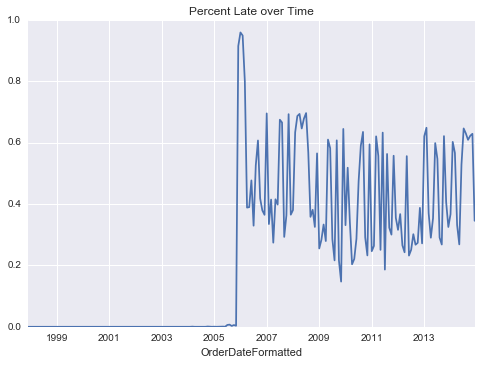

In [18]:
#shows the need to truncate data set

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsEmailOne'].mean().plot(kind = 'line', title = 'Percent Late over Time')

In [19]:
#tosses the former half of data which may not be relevant

USMTO_WHOLE = USMTO_WHOLE[(USMTO_WHOLE.OrderDateFormatted >= '2006-05-01')]

In [20]:
USMTO_WHOLE.columns

Index(['OrderID', 'AAID', 'NAICSID', 'CustomerZipCode', 'ShippingCountryID',
       'ShippingZipCode', 'Units', 'TotalSale', 'CreatedBy', 'CreateDate',
       'ChangedBy', 'IsSubmitted', 'TopCategoryName', 'SubCategory',
       'SubCategoryName', 'Description', 'MachineCode', 'EntryMonth',
       'EntryYear', 'Date', 'Close', 'IP', 'OrderDateFormatted',
       'ChangedDateFormatted', 'SubmitDateFormatted', 'OrderDateEOM',
       'DaysLate', 'IsEmailOne', 'IsEmailTwo', 'IsCall', 'IsBackfill'],
      dtype='object')

In [21]:
USMTO_WHOLE.describe()

,AAID,NAICSID,Units,TotalSale,IsSubmitted,SubCategory,MachineCode,EntryMonth,EntryYear,Close,IP,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill
count,392068.000000,392068.000000,392068.000000,3.920680e+05,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000
mean,101567.163523,451.643654,0.969559,1.511589e+05,0.999612,26.011322,3568.717931,6.866054,2010.319011,1424.766320,100.536678,14.907945,0.440000,0.303307,0.213754,0.031885
std,5267.014327,280.468735,0.234727,2.890960e+05,0.019686,9.751844,384.827128,3.410505,2.604354,282.721568,4.419017,92.569530,0.496388,0.459687,0.409955,0.175694
min,123.000000,1.000000,-1.000000,-9.861252e+06,0.000000,1.000000,3541.205000,1.000000,2006.000000,735.090027,87.412500,-39.000000,0.000000,0.000000,0.000000,0.000000
25%,100132.000000,209.000000,1.000000,4.598594e+04,1.000000,23.000000,3541.540000,4.000000,2008.000000,1267.380005,97.747400,-4.000000,0.000000,0.000000,0.000000,0.000000
50%,100333.000000,248.000000,1.000000,8.190807e+04,1.000000,23.000000,3541.704000,7.000000,2011.000000,1397.910034,101.601600,0.000000,0.000000,0.000000,0.000000,0.000000
75%,100525.000000,749.000000,1.000000,1.650000e+05,1.000000,36.000000,3541.708000,10.000000,2013.000000,1549.380005,104.172000,7.000000,1.000000,1.000000,0.000000,0.000000
max,123556.000000,924.000000,1.000000,4.475133e+07,1.000000,44.000000,9999.999000,12.000000,2014.000000,2067.560059,106.686800,3190.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
#create two new tables, one without outliers (outside 2 stdev), and one without backfillers (defined as submitted later than 100 days - per company definition)

USMTO_NO_SUBMIT_OUTLIERS = USMTO_WHOLE[np.abs(USMTO_WHOLE.DaysLate-USMTO_WHOLE.DaysLate.mean())<=(2*USMTO_WHOLE.DaysLate.std())] 
USMTO_NO_SUBMIT_BACKFILL = USMTO_WHOLE[USMTO_WHOLE.DaysLate <= 90]

#source: http://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe


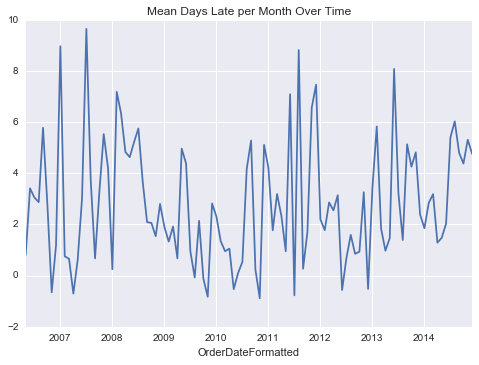

In [23]:
#Plots days late in a time series. Exhibit 1A, to be shared with team.

USMTO_NO_SUBMIT_BACKFILL.groupby(['OrderDateFormatted'])['DaysLate'].mean().plot(kind = 'line', title = 'Mean Days Late per Month Over Time')

In [24]:
#possible causes of change in oscillation
#box and whisker plots - how distribution changed over time
#change of median, edge, etc?
#potential companies that may have joined around 2005


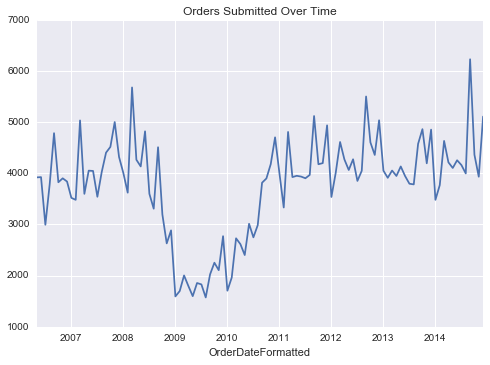

In [25]:
#plot order submission trend. Exhibit 2

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsSubmitted'].sum().plot(kind = 'line', title = 'Orders Submitted Over Time')

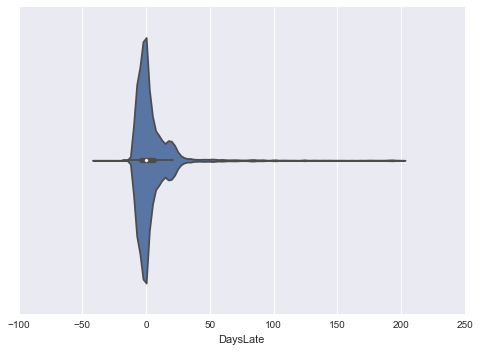

In [26]:
#plots distribution of days late

sns.violinplot(USMTO_NO_SUBMIT_OUTLIERS.DaysLate, title = 'Distribution of Days Late, 1997 to present')


In [27]:
#Creates table by AAID and OrderDateFormatted

AAID_BY_MONTH = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['DaysLate','TotalSale','IsEmailOne', 'IsEmailTwo', 'IsCall', 'IsBackfill','Close','IP'].mean()
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2 = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['Units','TotalSale'].sum()
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH = AAID_BY_MONTH.merge(AAID_BY_MONTH_2, how = 'inner', on = ['AAID','OrderDateFormatted'])
AAID_BY_MONTH['TotalSaleAvg'] = AAID_BY_MONTH['TotalSale_x']
AAID_BY_MONTH['TotalSale'] = AAID_BY_MONTH['TotalSale_y']
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_x', axis = 1)
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_y', axis = 1)
AAID_BY_MONTH.describe()

,AAID,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,Close,IP,Units,TotalSaleAvg,TotalSale
count,16973.000000,16973.000000,16973.000000,16973.000000,16973.000000,16973.000000,16973.000000,16973.000000,16973.000000,1.697300e+04,1.697300e+04
mean,104107.072880,32.490308,0.459377,0.355152,0.274082,0.055382,1384.751438,99.681026,22.396335,2.404865e+05,3.491697e+06
std,8553.490515,180.195489,0.498362,0.478574,0.446064,0.228731,293.845865,4.946221,82.426205,4.384656e+05,8.050759e+06
min,123.000000,-39.000000,0.000000,0.000000,0.000000,0.000000,735.090027,87.412500,-7.000000,-2.639510e+06,-7.234735e+06
25%,100251.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,1186.689941,96.495900,3.000000,7.504458e+04,4.630582e+05
50%,100496.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1365.680054,101.038200,8.000000,1.424250e+05,1.269340e+06
75%,100704.000000,11.000000,1.000000,1.000000,1.000000,0.000000,1514.680054,103.494100,19.000000,2.673460e+05,3.121388e+06
max,123556.000000,3190.000000,1.000000,1.000000,1.000000,1.000000,2067.560059,106.686800,1867.000000,1.700000e+07,1.212488e+08


In [28]:
#gets rid of all observations that are backfills
AAID_BY_MONTH_NO_BACKFILL = AAID_BY_MONTH[AAID_BY_MONTH.DaysLate <= 90]


In [29]:
#temporary fill in for adding in feature engineered vars until python script is written

AAID_BY_MONTH_NO_BACKFILL.to_csv('../Data/AAID By Month')
AAID_BY_MONTH_NO_BACKFILL = pd.DataFrame.from_csv('../Data/AAID By Month Edited.csv', index_col = False)
AAID_BY_MONTH_NO_BACKFILL['DaysLateLastThree'] = pd.to_numeric(AAID_BY_MONTH_NO_BACKFILL['DaysLateLastThree'])
AAID_BY_MONTH_NO_BACKFILL['TotalSaleLastThree'] = pd.to_numeric(AAID_BY_MONTH_NO_BACKFILL['TotalSaleLastThree'])
AAID_BY_MONTH_NO_BACKFILL = AAID_BY_MONTH_NO_BACKFILL.fillna(value = 0)


In [30]:
AAID_BY_MONTH_NO_BACKFILL.dtypes

AAID                    int64
OrderDateFormatted     object
DaysLate                int64
IsEmailOne              int64
IsEmailTwo              int64
IsCall                  int64
IsBackfill              int64
Close                 float64
Units                   int64
TotalSaleAvg          float64
TotalSale             float64
DaysLateLastThree     float64
TotalSaleLastThree    float64
DaysLateLast          float64
IP                    float64
IsCallLast            float64
UnitsLast             float64
TotalSaleAvgLast      float64
dtype: object

In [31]:
#create column "Three MMA Late" - which models the average of the past three month's lateness for each company

#AAID_BY_MONTH_NO_BACKFILL['Three_MMA_Late'] = AAID_BY_MONTH_NO_BACKFILL.DaysLate.ewm(span=3).mean()
#AAID_BY_MONTH_NO_BACKFILL.groupby(['OrderDateFormatted'])['Three_MMA_Late'].mean().plot(kind = 'line')


In [32]:
#AAID_BY_MONTH_NO_BACKFILL['Three_MMA_SalesTrend'] = AAID_BY_MONTH_NO_BACKFILL.TotalSale.ewm(span=3).mean()
#AAID_BY_MONTH_NO_BACKFILL.groupby(['OrderDateFormatted'])['Three_MMA_SalesTrend'].sum().plot(kind = 'line')

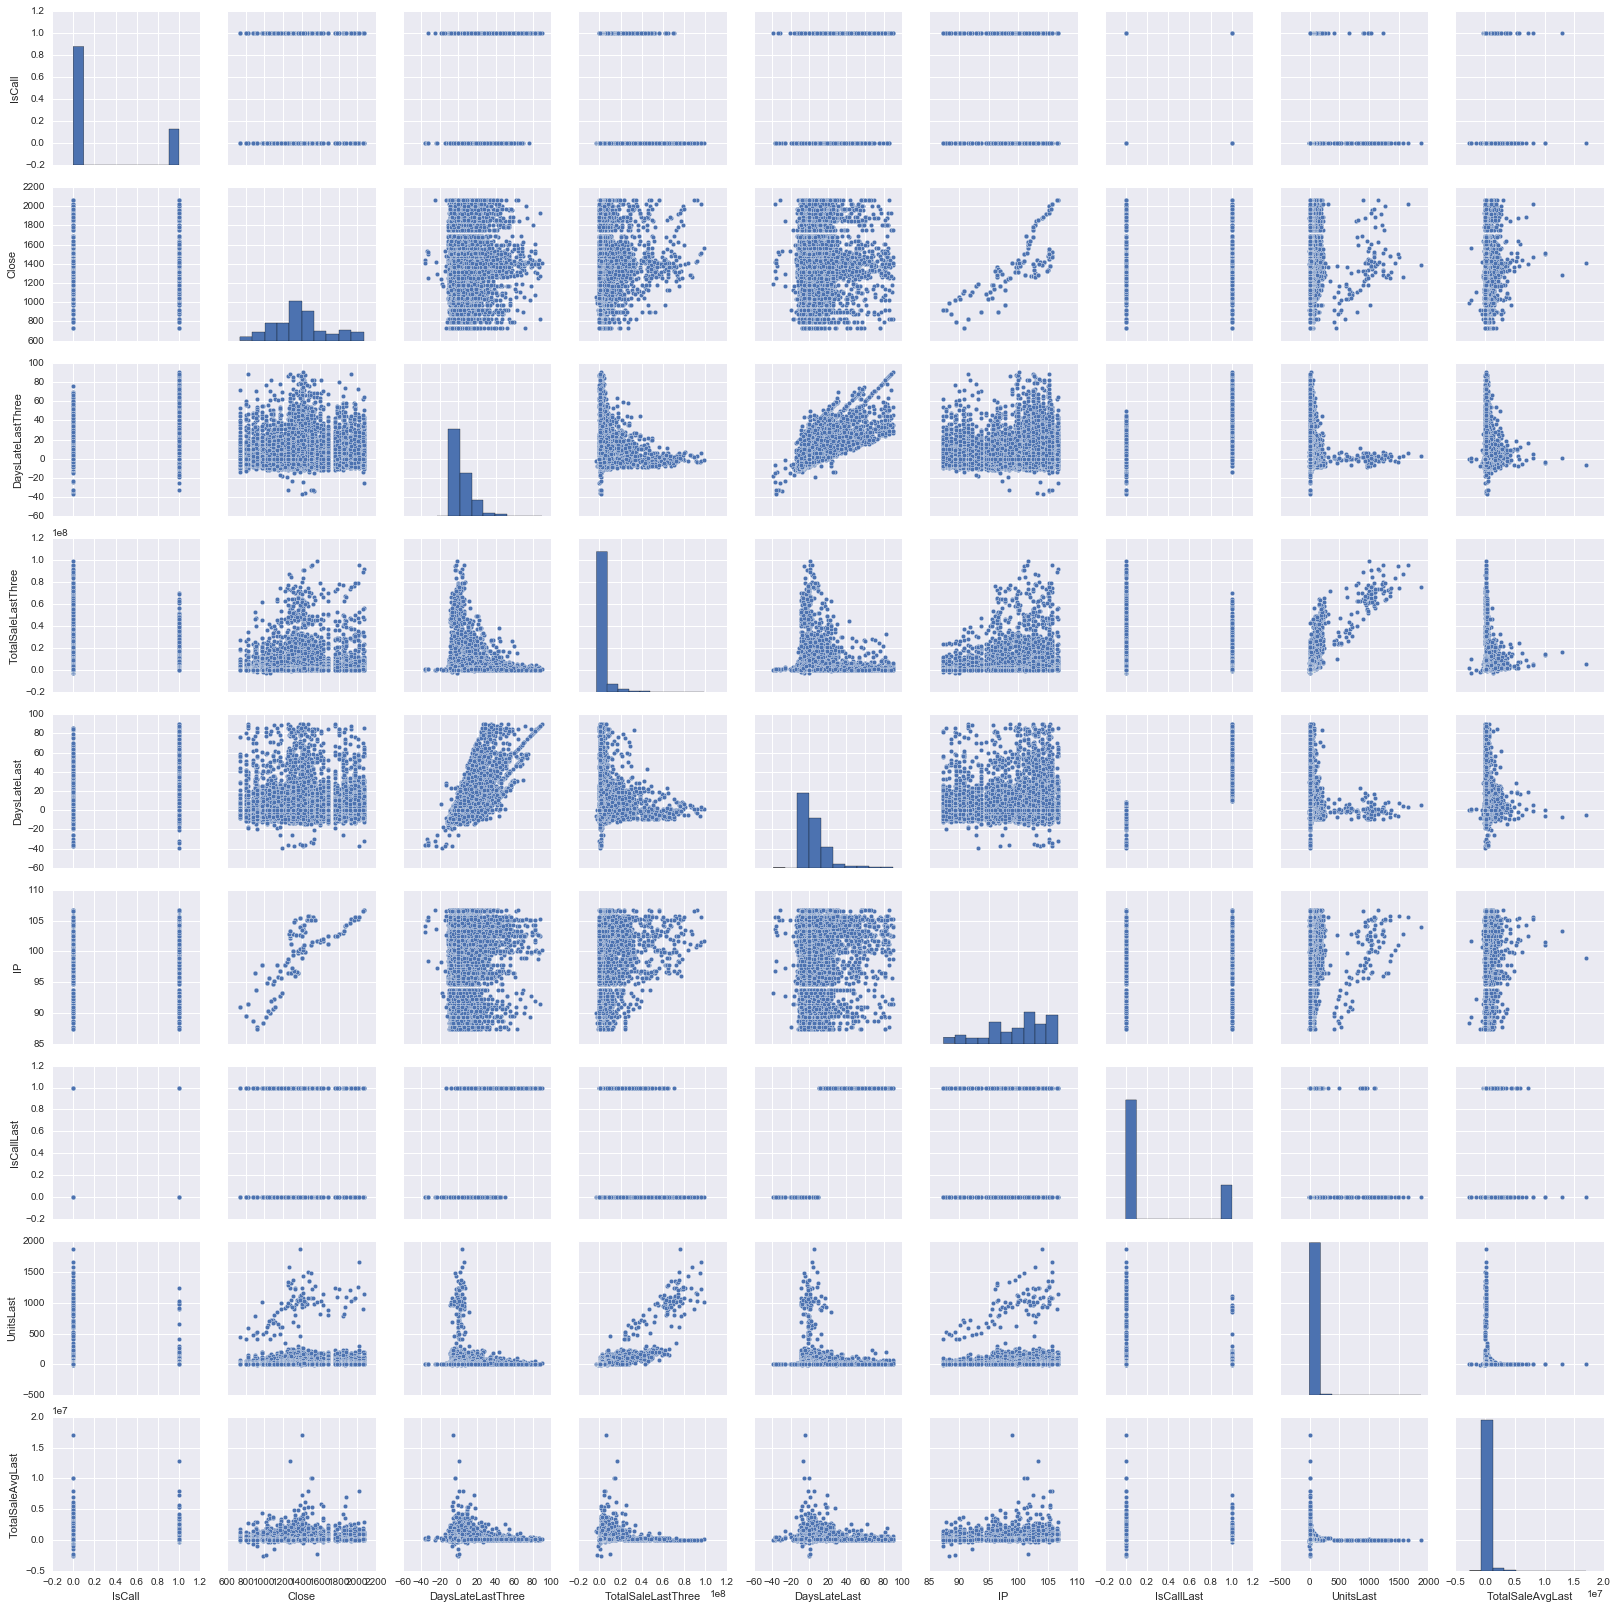

In [33]:
#scatter matrix identifying key features - target excluded

PAIRPLOT2 = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT2 = PAIRPLOT2.drop('AAID', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OrderDateFormatted', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailOne', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailTwo', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsBackfill', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('DaysLate', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSaleAvg', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Units', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSale', axis = 1)

sns.pairplot(PAIRPLOT2)

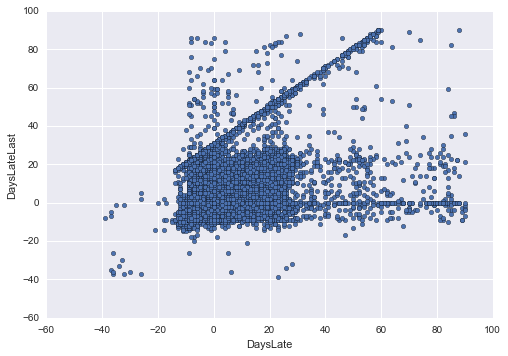

In [34]:
#DaysLate Last vs Days Late (suspicious line - business reason for this, not data error)

AAID_BY_MONTH_NO_BACKFILL.plot.scatter('DaysLate','DaysLateLast')

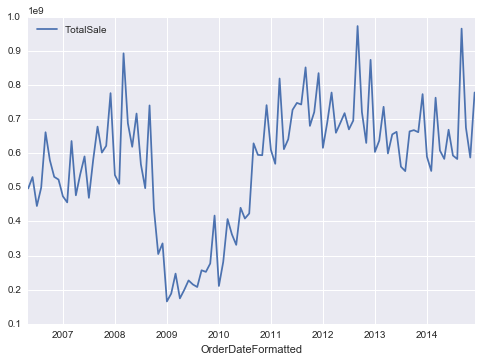

In [35]:
#average sales over time

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).sum()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='TotalSale')

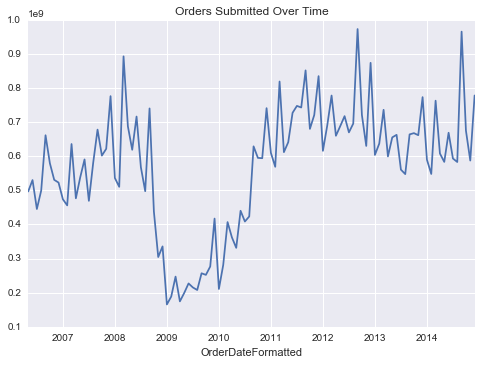

In [36]:
#plot of orders submitted over time

USMTO_WHOLE.groupby(['OrderDateFormatted'])['TotalSale'].sum().plot(kind = 'line', title = 'Orders Submitted Over Time')

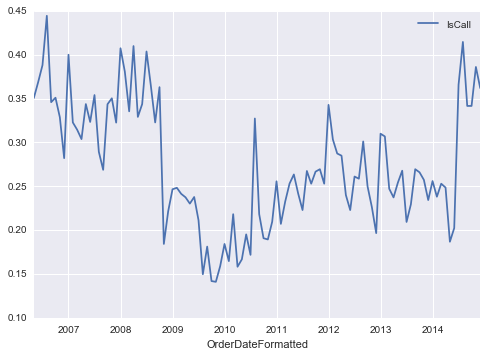

In [37]:
#percentage of company by month who needed to be called

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsCall')

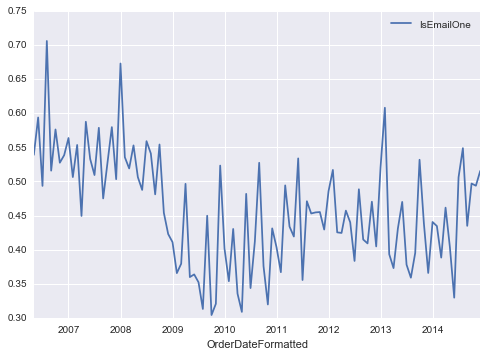

In [38]:
#percentage of company by month who needed to have first email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailOne')

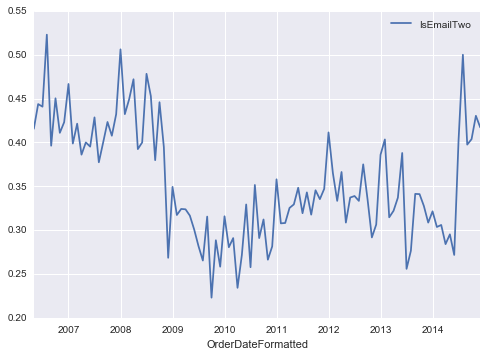

In [39]:
#percentage of company by month who needed to have second email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailTwo')

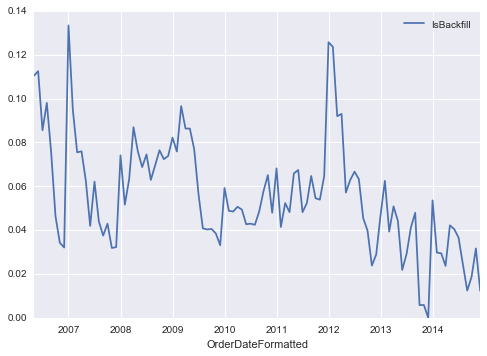

In [40]:
#percentage of company by month who backfilled

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsBackfill')

In [129]:
#prep for correlation matrix - target included. also the dataframe for machine learning algorithms

PAIRPLOT2 = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT2 = PAIRPLOT2.drop('AAID', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OrderDateFormatted', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailOne', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailTwo', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsBackfill', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('DaysLate', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSaleAvg', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Units', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSale', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('DaysLateLast', axis = 1)


corr2 = PAIRPLOT2.corr(method = 'pearson')

In [130]:
PAIRPLOT2.columns

Index(['IsCall', 'Close', 'DaysLateLastThree', 'TotalSaleLastThree', 'IP',
       'IsCallLast', 'UnitsLast', 'TotalSaleAvgLast'],
      dtype='object')

In [131]:
#Class Distribution

AAID_BY_MONTH_NO_BACKFILL.groupby('IsCall').size()

IsCall
0    12321
1     3719
dtype: int64

In [132]:
#Skew of Attributes

PAIRPLOT2.skew()

IsCall                 1.270878
Close                  0.369165
DaysLateLastThree      2.282692
TotalSaleLastThree     5.921180
IP                    -0.724223
IsCallLast             1.313808
UnitsLast             11.925780
TotalSaleAvgLast      12.234455
dtype: float64

In [133]:
PAIRPLOT2.corr()

,IsCall,Close,DaysLateLastThree,TotalSaleLastThree,IP,IsCallLast,UnitsLast,TotalSaleAvgLast
IsCall,1.000000,0.077764,0.468473,-0.008318,0.122950,0.461439,-0.028395,0.030896
Close,0.077764,1.000000,0.055856,0.063488,0.789642,0.068478,0.036185,0.028630
DaysLateLastThree,0.468473,0.055856,1.000000,0.000280,0.100720,0.669605,-0.018297,0.026482
TotalSaleLastThree,-0.008318,0.063488,0.000280,1.000000,0.080767,0.000166,0.788520,0.112716
IP,0.122950,0.789642,0.100720,0.080767,1.000000,0.108129,0.045953,0.030492
IsCallLast,0.461439,0.068478,0.669605,0.000166,0.108129,1.000000,-0.023003,0.032428
UnitsLast,-0.028395,0.036185,-0.018297,0.788520,0.045953,-0.023003,1.000000,-0.053644
TotalSaleAvgLast,0.030896,0.028630,0.026482,0.112716,0.030492,0.032428,-0.053644,1.000000


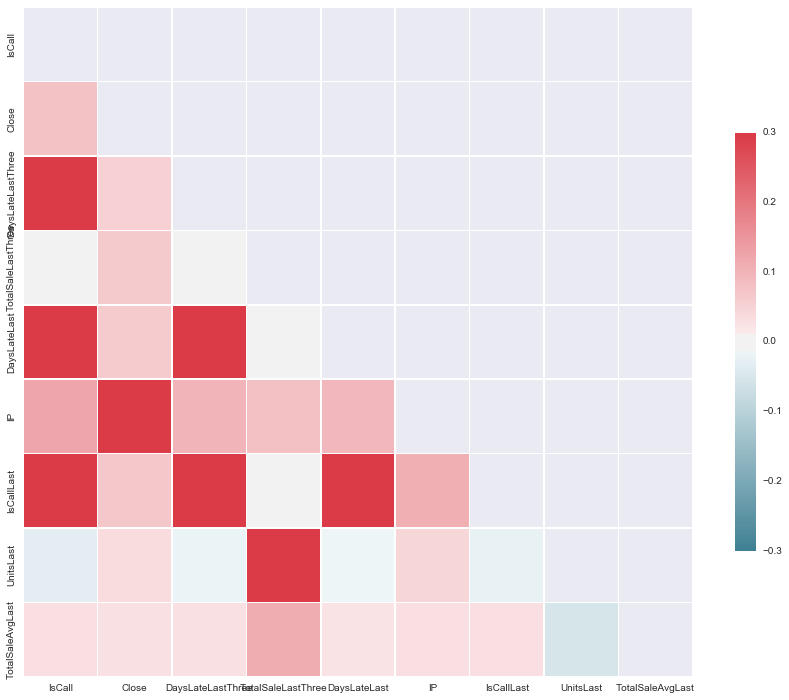

In [123]:
#Correlation Matrix Plot
import matplotlib.pyplot as plt

# Generate a mask for the upper triangle
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


In [134]:
#rescales all data to be between 0 and 1 and readies it for further processing - in progress

import scipy

from sklearn.preprocessing import MinMaxScaler

array = PAIRPLOT2.values
# separate array into input and output components
X = array[:,1:14]
Y = array[:,0]
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X)

rescaledX3 = rescaledX.reshape((-1,8))

rescaledX3 = pd.DataFrame({'Close':rescaledX[:,0],'DaysLateLastThree':rescaledX[:,1],'TotalSaleLastThree':rescaledX[:,2],'DaysLateLast':rescaledX[:,3],'IP':rescaledX[:,4],'IsCallLast':rescaledX[:,5],'UnitsLast':rescaledX[:,6],'TotalSaleAvgLast':rescaledX[:,7]})
sns.boxplot(data = rescaledX3, orient = 'h', fliersize = '1')

IndexError: index 7 is out of bounds for axis 1 with size 7

In [48]:
#relationship between last month's days late and this month's call

#rescaledX3.plot.scatter('DaysLateLast','IsCall')

In [135]:
# Feature Importance with Extra Trees Classifier

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]

# feature extraction
model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

[ 0.07782676  0.25741206  0.14125629  0.08182394  0.1636526   0.13219388
  0.14583447]


In [136]:
# Feature Extraction with RFE 

from sklearn.feature_selection import RFE
# load data

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 4)
fit = rfe.fit(X, Y)
print("Num Features: " , fit.n_features_)
print("Selected Features: " , fit.support_)
print("Feature Ranking: " , fit.ranking_)

Num Features:  4
Selected Features:  [False  True False  True  True  True False]
Feature Ranking:  [2 1 4 1 1 1 3]


In [137]:
#Feature Extraction with PCA - in progress

from sklearn.decomposition import PCA
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
# feature extraction
pca = PCA(n_components=4)
fit = pca.fit(X)
# summarize components
print("Explained Variance: ", fit.explained_variance_ratio_)
print(fit.components_)

Explained Variance:  [  9.97095886e-01   2.90411210e-03   1.47528054e-09   4.27955413e-11]
[[  2.44763312e-06   4.55202764e-10   9.99981150e-01   5.21186790e-08
    9.65132308e-12   8.63864983e-06   6.14007016e-03]
 [ -1.54219717e-05  -7.78158835e-07   6.14006995e-03  -2.57036866e-07
   -3.29530532e-08   2.91722616e-05  -9.99981149e-01]
 [  9.99905477e-01   2.27649690e-03  -2.32538383e-06   1.31833591e-02
    9.63963592e-05  -3.16924793e-03  -1.55327022e-05]
 [ -3.19617724e-03   6.02089902e-03   8.82489392e-06   9.83888274e-04
    2.54426892e-04  -9.99976249e-01  -2.90735865e-05]]


In [138]:
#we end up using all features

In [139]:
#test different types of models

array = PAIRPLOT2.values
X = array[:,1:14].astype(float)
Y = array[:,0]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y,
test_size=validation_size, random_state=seed)
num_folds = 10
num_instances = len(X_train)
seed = 7
scoring = 'accuracy'
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC())) - causes code to hang
results = []
names = []
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = (name, cv_results.mean(),cv_results.std())
    print(msg)


('LR', 0.7727530879485629, 0.012194386379087712)
('LDA', 0.82208456863416401, 0.012506772079978681)
('KNN', 0.73308718370835479, 0.011350920095676354)
('DTC', 0.752570457674405, 0.010760406149965892)
('NB', 0.76316745701638733, 0.012597609735277602)


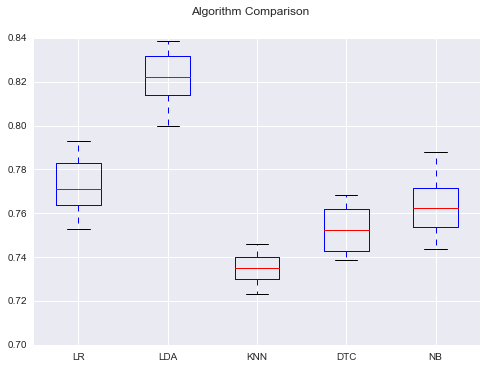

In [140]:
#distribution of models

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [142]:
#classification report with best model (Decision Trees)

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = LinearDiscriminantAnalysis()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.86      0.90      0.88      4043
        1.0       0.63      0.54      0.58      1251

avg / total       0.81      0.82      0.81      5294



In [148]:
>>> from sklearn import tree
>>>
>>> clf = tree.DecisionTreeClassifier()
>>> clf = clf.fit(X_train, Y_train)
>>> tree.export_graphviz(clf,
...     out_file='usmto3.dot',feature_names = a.columns)   

In [147]:
>>> from sklearn.externals.six import StringIO
>>> with open("usmto3.dot", 'w') as f:
...     f = tree.export_graphviz(clf, out_file=f)

>>> import os
>>> os.unlink('usmto3.dot')

In [77]:
PAIRPLOT2.head()

,IsCall,Close,DaysLateLastThree,TotalSaleLastThree,DaysLateLast,IP,IsCallLast,UnitsLast,TotalSaleAvgLast
0,0,1270.089966,0.000000,0.0000,0.0,102.1531,0.0,0.0,0.00000
1,0,1270.199951,-5.000000,307891.0000,-5.0,102.5220,0.0,7.0,131438.71430
2,0,1276.660034,-2.000000,472786.5000,1.0,102.5057,0.0,2.0,153945.50000
3,1,1303.819946,-4.000000,621881.3333,-8.0,102.8357,0.0,11.0,57971.09091
4,0,1377.939941,2.666667,337189.0000,15.0,102.6297,1.0,1.0,65994.00000


In [115]:
a = pd.DataFrame({'Close':X[:,0],'DaysLateLastThree':X[:,1],'TotalSaleLastThree':X[:,2],'DaysLateLast':X[:,3],'IP':X[:,4],'IsCallLast':X[:,5],'UnitsLast':X[:,6],'TotalSaleAvgLast':X[:,7]}).head()

a

,Close,DaysLateLast,DaysLateLastThree,IP,IsCallLast,TotalSaleAvgLast,TotalSaleLastThree,UnitsLast
0,1270.089966,0.0,0.000000,102.1531,0.0,0.00000,0.0000,0.0
1,1270.199951,-5.0,-5.000000,102.5220,0.0,131438.71430,307891.0000,7.0
2,1276.660034,1.0,-2.000000,102.5057,0.0,153945.50000,472786.5000,2.0
3,1303.819946,-8.0,-4.000000,102.8357,0.0,57971.09091,621881.3333,11.0
4,1377.939941,15.0,2.666667,102.6297,1.0,65994.00000,337189.0000,1.0


In [88]:
pd.DataFrame({'Target':Y[]}).head()

IndexError: too many indices for array

In [ ]:
# Cross Validation Classification LogLoss (smaller logloss better with 0 as perfect logloss)


from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:8]
Y = array[:,0]
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = LinearDiscriminantAnalysis()
scoring = 'log_loss'
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring = scoring)
print("Logloss: ", results.mean(), "      Std Dev: ", results.std()*100.0)

In [ ]:
# Cross Validation Classification with Area Under the Curve (Between 0.5 and 1 indicates good model)


from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:8]
Y = array[:,0]
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = LinearDiscriminantAnalysis()
scoring = 'roc_auc'
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring = scoring)
print("AUC: ", results.mean(), "      Std Dev: ", results.std()*100.0)

In [ ]:
#APPENDIX AS FOLLOWS: (works in progress)

In [ ]:
#cols to create:

#3 MMA company sales
#3 MMA lateness
# s&p 500 
machine tool mix
#prior month late days
# scatter matrix



In [ ]:
#attempts to map which AAIDs submitted over what dates

AAIDs = pd.DataFrame.from_csv('AAIDs.csv', index_col = False)

In [ ]:
AAIDs = AAIDs.fillna('')

In [ ]:
AAIDs

In [ ]:
#plots distribution who received a first email, over all time

USMTO_WHOLE.groupby('OrderDateFormatted')['IsEmailOne'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsEmailTwo'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsCall'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsBackfill'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE